# ##  Explanation of Step 3: Temporal Drift Analysis

### a. What this code is about
This code analyzes the tracking **error** from Step 2 to see if it gets **worse over time**. This problem is called **"temporal drift"**.

In simple terms, it checks: "Is my tracking model accurate at the beginning of the video but gradually becomes less accurate by the end?"

It reads the frame-by-frame error file (`error_by_frame.csv`) and creates simple summary reports and plots to show you exactly which cameras (`cam`) and body parts (`node`) have this drift problem.

---
### b. How it works (Methodology)
1.  **Input:** It loads the `error_by_frame.csv` file you created in Step 2.
2.  **Grouping:** It separates all the error data by **camera** and **body part** (e.g., "Camera 1 - head", "Camera 1 - tail", "Camera 2 - head", etc.).
3.  **Core Calculation (Linear Regression):** For each unique (`cam`, `node`) pair, it looks at two variables:
    * `x` = The frame number (which represents time)
    * `y` = The tracking error in pixels (`err_px`)
    It then fits a straight line (a "linear regression") to this data to find the **trend**.
4.  **Find the "Slope":** The most important result is the **slope** of that line.
    * A **flat slope (near 0)** means the error stays the same over time. This is **GOOD**.
    * A **positive slope** (e.g., `+2.5`) means the error *increases* as the video goes on. This is **BAD (drift)**.
    * A **negative slope** (e.g., `-1.8`) means the error *decreases*. This is also a form of drift.
5.  **Scaling:** To make it easy to compare, it scales this slope to measure **"pixels of drift per 10,000 frames"** (`slope_px_per_10k`).
6.  **Categorizing:** It labels each pair's trend as **"Flat"**, **"Slight"**, or **"Drift"** based on the slope thresholds you set.

---
### c. Output it produces (Output files)
This code creates a new folder: `C:\Users\Lenovo\Desktop\Sleap evaluation\out_metrics\[session_name]\metrics_step3\`

Inside this new folder, it saves **two CSV files** and **two PNG image files**.

---
### d. What each file means?

* `drift_by_cam_node.csv`:
    * This is the **main results file**. Each row is one `(cam, node)` pair.
    * It tells you the exact `slope_px_per_10k` (the drift amount), `r2` (how well the trend line fits the data), and the `trend` label ("Flat", "Drift ↓", "Drift ↑", etc.).

* `top_issues.csv`:
    * This file contains the **exact same information** as `drift_by_cam_node.csv`.
    * The only difference is it's **sorted** to show the *worst* drift (biggest absolute slope) at the very top. This is the best file to open first to see your biggest problems immediately.

* `drift_heatmap.png`:
    * This is a **visual summary** of all results. It's a grid (a heatmap) where:
        * Rows = Cameras
        * Columns = Body parts (`nodes`)
        * Color = The drift amount (`slope_px_per_10k`)
    * This helps you spot patterns at a glance. For example, a single row that is very bright or dark means that *one camera* has a drift problem across *all* body parts.

* `rolling_example.png`:
    * This is a detailed plot of the **single worst-drifting pair** (the first row from `top_issues.csv`).
    * It plots the error over time (frame number) and draws a smoothed "rolling median" line to make the drift trend very easy to see.

---
### e. Console output types and what each means?

* `[info] Using error file: ...`: This confirms which input file (from Step 2) it found and is analyzing.
* `[info] Writing to: ...`: This confirms which output folder it is saving all the new files (CSVs and PNGs) into.
* `[OK] wrote: ...`: These are success messages. You'll see one after each file is successfully created and saved.
* `=== Quick Summary (top 8 by |slope|) ===`: This is the final, most important console output. It prints a summary of the top 8 worst-drifting pairs directly to your screen, so you can see the main results instantly without having to open any files.

---
### f. How this code helps us
This code is crucial for checking the **long-term reliability** of your tracking model.

A model might look perfect in the first 1,000 frames, but if it has "drift," it could be completely wrong by frame 50,000. This code helps you **diagnose this problem automatically**.

By finding which cameras and nodes are drifting, you know exactly where the problems are. This allows you to:
* Decide if you need to **re-train your model** with more labeled data from *later* in the videos.
* Know if you need to **manually correct** the labels in the sections that are drifting.
* Be cautious about trusting the tracking data from very long videos if significant drift is found.

### Quick note on R² and "px per 10k frames"

**R² (pronounced R-squared)**  
R² tells us how well a straight line explains the change in error over time.
- R² = 1.0 means: the error follows a very clean line (perfect trend).
- R² = 0.0 means: the error is just noisy/random, no clear trend.
Example:  
If `L_star` on `cam-topright` has `R² = 0.75`, that means 75% of the changes in error are explained by a simple “it keeps getting worse over time” line. That’s real drift, not random flicker.

**slope_px_per_10k (px per 10,000 frames)**  
This is “how fast the error is drifting,” scaled to something readable.
- The raw slope is pixels per frame, which is usually a tiny number like 0.00042 px/frame.
- We multiply by 10,000 so it becomes “4.2 px per 10k frames,” which we can read.

Example:  
If slope_px_per_10k = +5.0 for `U_star` on `cam-bottomleft`, that means:
- Over the duration, the tracker for `U_star` drifts about +5 pixels worse across 10,000 frames.
- Positive = getting worse (↑).  
- Negative = getting better (↓).  
Near 0 = stable (Flat).


### About the Step 3 hyperparameters

These values control how strict the drift analysis is. They are not coming from math laws — they are our chosen settings.

1. **min_points_per_pair = 12**  
   - Meaning: Only analyze a (camera, node) pair if we have at least 12 labeled points for it.
   - Why: If we only saw that node 2–3 times, we can’t trust the slope. 12+ is "enough data to believe the trend."
   - If you LOWER it (e.g. 5): you'll get more pairs in the table, but some slopes will be garbage/noisy.  
   - If you RAISE it (e.g. 50): you'll get only strong, confident pairs, but you might miss some nodes entirely.

2. **roll_window_frames = 501**  
   - Meaning: when we draw the "rolling median" line in the last plot, we smooth over 501 frames.
   - Why: raw per-frame error jumps a lot. Smoothing lets us see the drift shape instead of noise.
   - If you LOWER it (e.g. 101): line will react faster, but will look more wiggly/noisy.
   - If you RAISE it (e.g. 1001): line will be very smooth, but slow to show sudden jumps.

3. **slope_flag_flat = 1.0**  
   - Meaning: if |drift| ≤ 1 pixel per 10,000 frames → call it `"Flat"`.
   - Why: super tiny movement (<1 px over the whole session) is basically nothing.
   - If you LOWER it (e.g. 0.5): you become more sensitive, you’ll call more things "Slight" instead of "Flat".
   - If you RAISE it (e.g. 2.0): you become more relaxed, small drifts will be treated as "Flat / fine".

4. **slope_flag_slight = 3.0**  
   - Meaning:
     - If drift is between 1 and 3 px per 10k frames → `"Slight ↑"` / `"Slight ↓"`
     - If drift is >3 px per 10k frames → `"Drift ↑"` / `"Drift ↓"`
   - Why: >3 px per 10k frames is probably real trouble (marker sliding on skin, calibration off, etc.).
   - If you LOWER it (e.g. 2.0): you will call "Drift" more aggressively.
   - If you RAISE it (e.g. 5.0): you will only mark "Drift" for very large problems.

---

#### TL;DR
- These are hyperparameters = tuning knobs.
- We use them so we can (1) ignore garbage data, (2) smooth noise, and (3) label drift as Flat / Slight / Drift in human language.
- You *can* change them. Changing them does not break the code — it just changes how strict the report is.

So: smaller thresholds = more sensitive / more alarms.  
Bigger thresholds = more forgiving / fewer alarms.


[info] Using error file: C:\Users\Lenovo\Desktop\Sleap evaluation\out_metrics\Sleap evaluation\metrics_step2\error_by_frame.csv
[info] Writing to: C:\Users\Lenovo\Desktop\Sleap evaluation\out_metrics\Sleap evaluation\metrics_step3
[OK] wrote: C:\Users\Lenovo\Desktop\Sleap evaluation\out_metrics\Sleap evaluation\metrics_step3\drift_by_cam_node.csv
[OK] wrote: C:\Users\Lenovo\Desktop\Sleap evaluation\out_metrics\Sleap evaluation\metrics_step3\top_issues.csv


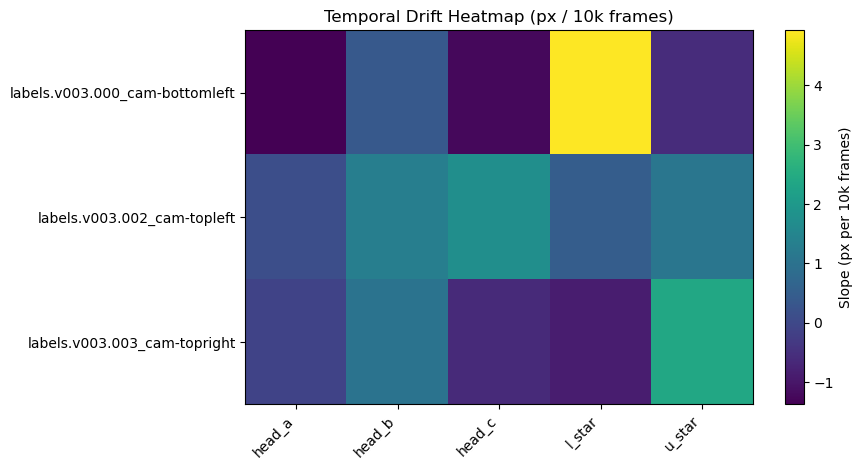

[OK] wrote: C:\Users\Lenovo\Desktop\Sleap evaluation\out_metrics\Sleap evaluation\metrics_step3\drift_heatmap.png


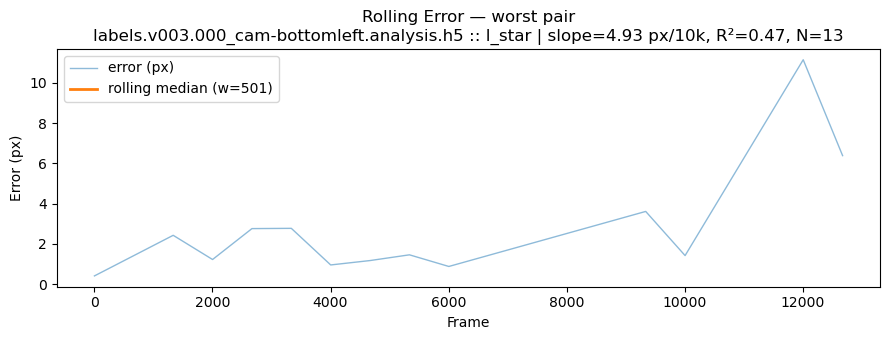

[OK] wrote: C:\Users\Lenovo\Desktop\Sleap evaluation\out_metrics\Sleap evaluation\metrics_step3\rolling_example.png

=== Quick Summary (top 8 by |slope|) ===
labels.v003.000_cam-bottomleft.analysis.h5 :: l_star: +4.93 px/10k (↑), R²=0.47, N=13, Drift ↑
labels.v003.003_cam-topright.analysis.h5 :: u_star: +2.41 px/10k (↑), R²=0.36, N=14, Slight ↑
labels.v003.002_cam-topleft.analysis.h5 :: head_c: +1.74 px/10k (↑), R²=0.13, N=16, Slight ↑
labels.v003.000_cam-bottomleft.analysis.h5 :: head_a: -1.38 px/10k (↓), R²=0.24, N=13, Slight ↓
labels.v003.002_cam-topleft.analysis.h5 :: head_b: +1.32 px/10k (↑), R²=0.11, N=16, Slight ↑
labels.v003.000_cam-bottomleft.analysis.h5 :: head_c: -1.25 px/10k (↓), R²=0.08, N=13, Slight ↓
labels.v003.002_cam-topleft.analysis.h5 :: u_star: +1.10 px/10k (↑), R²=0.29, N=16, Slight ↑
labels.v003.003_cam-topright.analysis.h5 :: head_b: +1.04 px/10k (↑), R²=0.06, N=14, Slight ↑


In [2]:
# === STEP 3 (Temporal Drift) — minimal outputs ===
# Reads Step-2 error_by_frame.csv and produces compact drift metrics + 2 plots.

# --- EDIT THESE ---
session_dir = r"C:\Users\Lenovo\Desktop\Sleap evaluation"             # same as Step 2
out_root    = r"C:\Users\Lenovo\Desktop\Sleap evaluation\out_metrics" # same as Step 2
# If you changed Step 2 paths, set error_csv directly; else leave "" and we auto-locate it.
error_csv_override = r""  # e.g., r"C:\path\to\error_by_frame.csv" or ""

# --- Params (keep simple) ---
min_points_per_pair = 12       # skip very tiny samples
roll_window_frames  = 501      # for the example rolling plot (odd number recommended)
slope_flag_flat     = 1.0      # |slope| ≤ 1 px/10k => "Flat"
slope_flag_slight   = 3.0      # 1–3 px/10k => "Slight"; >3 => "Drift"

# -----------------------------
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Locate inputs / outputs ---
session_name = os.path.basename(os.path.normpath(session_dir))
step2_dir = os.path.join(out_root, session_name, "metrics_step2")
if error_csv_override:
    err_csv = error_csv_override
else:
    err_csv = os.path.join(step2_dir, "error_by_frame.csv")

if not os.path.isfile(err_csv):
    raise FileNotFoundError(f"Can't find Step-2 error_by_frame.csv at:\n{err_csv}")

step3_dir = os.path.join(out_root, session_name, "metrics_step3")
os.makedirs(step3_dir, exist_ok=True)

print("[info] Using error file:", err_csv)
print("[info] Writing to:", step3_dir)

# --- Load errors ---
df = pd.read_csv(err_csv)
need_cols = {"cam", "frame", "node", "err_px"}
if not need_cols.issubset(df.columns):
    raise ValueError(f"error_by_frame.csv must contain {need_cols}. Got: {list(df.columns)}")
df = df.copy()
df["cam"]  = df["cam"].astype(str)
df["node"] = df["node"].astype(str)
df["frame"]= df["frame"].astype(int)
df = df.dropna(subset=["err_px"])

# --- Helpers ---
def linregress_slope_r2(x, y):
    """Return slope, intercept, R^2 using simple OLS (no SciPy)."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    xm, ym = x.mean(), y.mean()
    sxx = np.sum((x - xm)**2)
    if sxx <= 0:
        return np.nan, np.nan, 0.0
    slope = np.sum((x - xm)*(y - ym)) / sxx
    intercept = ym - slope * xm
    yhat = intercept + slope * x
    ss_tot = np.sum((y - ym)**2)
    ss_res = np.sum((y - yhat)**2)
    r2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    return float(slope), float(intercept), float(max(0.0, min(1.0, r2)))

def trend_label(slope_10k):
    a = abs(slope_10k)
    if a <= slope_flag_flat:  return "Flat"
    if a <= slope_flag_slight:return "Slight ↑" if slope_10k>0 else "Slight ↓"
    return "Drift ↑" if slope_10k>0 else "Drift ↓"

# --- Compute drift per camera × node ---
rows = []
for (cam, node), g in df.groupby(["cam","node"]):
    g = g.sort_values("frame")
    n = len(g)
    if n < min_points_per_pair:
        continue
    slope, b0, r2 = linregress_slope_r2(g["frame"].values, g["err_px"].values)
    slope_10k = slope * 10000.0  # px per 10k frames (scale-invariant)
    rows.append(dict(cam=cam, node=node, n=n, slope_px_per_10k=slope_10k, r2=r2))

drift = pd.DataFrame(rows).sort_values(["cam","node"]).reset_index(drop=True)
if drift.empty:
    raise RuntimeError("No pairs with enough points. Lower min_points_per_pair if needed.")

drift["trend"] = drift["slope_px_per_10k"].apply(trend_label)

# Save main table
drift_csv = os.path.join(step3_dir, "drift_by_cam_node.csv")
drift.to_csv(drift_csv, index=False)
print("[OK] wrote:", drift_csv)

# Save compact "top issues"
top = drift.reindex(drift["slope_px_per_10k"].abs().sort_values(ascending=False).index)
top_csv = os.path.join(step3_dir, "top_issues.csv")
top.to_csv(top_csv, index=False)
print("[OK] wrote:", top_csv)

# --- Heatmap (one picture) ---
cams  = sorted(drift["cam"].unique())
nodes = sorted(drift["node"].unique())
mat = np.full((len(cams), len(nodes)), np.nan)
for i, c in enumerate(cams):
    for j, n in enumerate(nodes):
        sub = drift[(drift["cam"]==c) & (drift["node"]==n)]
        if len(sub)==1:
            mat[i,j] = sub["slope_px_per_10k"].values[0]

plt.figure(figsize=(1.2*len(nodes)+3, 0.6*len(cams)+3))
im = plt.imshow(mat, aspect="auto", interpolation="nearest")
plt.colorbar(im, label="Slope (px per 10k frames)")
plt.xticks(range(len(nodes)), nodes, rotation=45, ha="right")
plt.yticks(range(len(cams)), [c.replace(".analysis.h5","") for c in cams])
plt.title("Temporal Drift Heatmap (px / 10k frames)")
plt.tight_layout()
heatmap_path = os.path.join(step3_dir, "drift_heatmap.png")
plt.savefig(heatmap_path, dpi=150)
plt.show()
print("[OK] wrote:", heatmap_path)

# --- Rolling example (just the worst pair) ---
worst = top.iloc[0]
wc, wn = worst["cam"], worst["node"]
g = df[(df["cam"]==wc) & (df["node"]==wn)].sort_values("frame")
# simple rolling median for display (ignore edges)
w = roll_window_frames
if w % 2 == 0: w += 1
roll = g["err_px"].rolling(window=w, center=True, min_periods=max(5, w//5)).median()

plt.figure(figsize=(9,3.5))
plt.plot(g["frame"].values, g["err_px"].values, linewidth=1, alpha=0.5, label="error (px)")
plt.plot(g["frame"].values, roll.values, linewidth=2, label=f"rolling median (w={w})")
plt.xlabel("Frame")
plt.ylabel("Error (px)")
ttl = f"Rolling Error — worst pair\n{wc} :: {wn} | slope={worst['slope_px_per_10k']:.2f} px/10k, R²={worst['r2']:.2f}, N={int(worst['n'])}"
plt.title(ttl)
plt.legend()
plt.tight_layout()
roll_path = os.path.join(step3_dir, "rolling_example.png")
plt.savefig(roll_path, dpi=150)
plt.show()
print("[OK] wrote:", roll_path)

# --- Console summary (quick read) ---
def label_arrow(s):
    return "↑" if s>0 else ("↓" if s<0 else "—")
print("\n=== Quick Summary (top 8 by |slope|) ===")
for _, r in top.head(8).iterrows():
    print(f"{r['cam']} :: {r['node']}: {r['slope_px_per_10k']:+.2f} px/10k ({label_arrow(r['slope_px_per_10k'])}), "
          f"R²={r['r2']:.2f}, N={int(r['n'])}, {r['trend']}")
